# Aula - redução de dimensionalidade

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) PCA
- 2) PCA na Pipeline
- 3) Vantagens e Desvantagens


## Motivação:
- Temos muitas features e queremos reduzir a quantidade
- Sabemos que que temos features que não são relevantes
- Reduzir ruído ao eliminar componentes menos importantes
- Reduzir probabilidade de overfiting
- Pode melhorar o score do modelo
- Acelera o treinamento
- Facilita a visualização de dados
- Criar features novas baseadas nas existentes

<img src="images/pre-processing_order.png" />

In [1]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

____
_____

## 1) PCA

**Objetivo:**
Queremos criar um novo conjunto de features que seja menor e capaz de resumir e manter as principais propriedades contidas no conjunto original de dados. Para isso, faremos uma transformação que irá converter um conjunto de dados X em um novo conjunto X' por meio de uma combinação linear.

### Intuição
Suponha que você quer tirar uma foto dos seus amigos que estão nas posições representadas abaixo, qual das três alternativas seria melhor?

<img src="images/pca_intuition.png" width=500 text="https://www.youtube.com/watch?v=g-Hb26agBFg&t=72s" />

É isso que o PCA faz, ele tira uma "foto" dos seus dados de um novo ângulo de forma a manter a maior quantidade de dados.

### O que o PCA faz?
PCA (principal component analysis) é uma técnica **não supervisionada** que determina **as direções de máxima variância** no espaço de features, de modo que **as direções são ortogonais entre si**.

Ou seja,

> A primeira componente principal é a direção que maximiza a variáncia dos dados projetados em sua direção; A segunda componente principal é uma direção ortogonal à primeira que também maximiza a variância nesta direção, e assim sucessivamente.

<img src=https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png width=400>

É importante lembrar que:

- Se o espaço original tem $n$ features, é possível construir $n$ componentes principais;<br><br>
- Cada componente principal é uma **combinação linear das features originais**;<br><br>
- As componentes principais são ortogonais entre si;<br><br>
- As componentes principais são linearmente descorrelacionadas;<br>

É muito comum que PCA seja utilizada como uma técnica de **redução de dimensionalidade**, isto porque, **no espaço transformado de componentes principais**, é comum que grande parte da variância completa dos dados esteja contida nas $L$ primeiras componentes principais ($L < n$).

Sendo assim, ao invés de utilizar o espaço de features completo (de dimensão $n$) para a construção de modelos, podemos utilizar apenas $L$ dimensões **do espaço de features de componentes principais**, reduzindo, assim, a dimensionalidade do espaço de features efetivo em que os estimadores irão trabalhar.

Os objetivos desta redução podem ser:

- Evitar a maldição da dimensionalidade;
- Treinar modelos mais rápido (de maneira mais eficiente), afinal, há menos dados;
- Fornecer dados sem qualquer colinearidade (há estimadores que assumem não-colinearidade!)

### 1.1) Como o PCA faz?

O PCA primeiro translada os dados pro eixo (0,0) e depois projeta os nossos pontos em novos eixos e escolhe os que possuem maior variância (chamados de componentes principais). Isso é feito para reduzir a perda de informação que possam impactar na predição do modelo.

No gif abaixo estamos projetando nossos dados bidimensionais em uma única dimensão.

<img src=https://img-blog.csdnimg.cn/20200216202613847.gif width=500>

### O que é cada PC?

Como dissemos acima, cada componente principal é uma **combinação linear das features originais**.

Nesse sentido, podemos enxergar o PCA como um método que constrói um novo espaço de features, de mesma dimensão que o espaço original:

<img src=https://miro.medium.com/max/1200/1*V3JWBvxB92Uo116Bpxa3Tw.png width=700>

O ponto é que o espaço de features construído pelo PCA é muito particular: as novas features são ortogonais entre si, e tais que maximizam a variância dos dados em cada sub-espaço de projeção, como dissemos acima.

Assim, na prática, seja um espaço de input $\mathcal{X}$ de $n$ dimensões, tal que cada vetor de features $\vec{x} \in \mathcal{X}$ é dado por:

$$ \vec{x} = \left ( x_1, x_2, x_3, \cdots , x_n \right) $$

Após a aplicação do PCA, estaremos no espaço de componentes principais, tal que um vetor de features neste espaço, $\vec{x}_{PC}$, será dado por:

$$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, \cdots , PC_n \right) $$

Onde cada componente principal é uma combinação linear das features originais, isto é, 

$$ PC_i = \sum_{k=1}^n \alpha_{i, k} x_k = \alpha_{i, 1} x_1 +  \alpha_{i, 2} x_2 + \cdots +  \alpha_{i, n} x_n$$

Note que cada componente principal $i$ tem $n$ coeficientes diferentes $\alpha_{i, k}$, que acompanham cada uma das features $k$ do espaço original.

Para entender melhor, vamos tomar um dataset bem simples!

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris(as_frame=True)

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [3]:
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
8,4.4,2.9,1.4,0.2
106,4.9,2.5,4.5,1.7
76,6.8,2.8,4.8,1.4
9,4.9,3.1,1.5,0.1
89,5.5,2.5,4.0,1.3


No caso do dataset iris, temos 4 features, de modo que o espaço original tem 4 dimensões e um vetor de features pode ser descrito por:

$ \vec{x} = (x_1, x_2, x_3, x_4)$.

Sendo que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Assim, esperamos que após o PCA, o espaço de componentes principais também tenha 4 dimensões, isto é, 

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, PC_4 \right) $

E as componentes principais serão: 

$ PC_1 = \alpha_{1, 1} x_1 + \alpha_{1, 2} x_2 + \alpha_{1, 3} x_3 + \alpha_{1, 4} x_4$

$ PC_2 = \alpha_{2, 1} x_1 + \alpha_{2, 2} x_2 + \alpha_{2, 3} x_3 + \alpha_{2, 4} x_4$

$ PC_3 = \alpha_{3, 1} x_1 + \alpha_{3, 2} x_2 + \alpha_{3, 3} x_3 + \alpha_{3, 4} x_4$

$ PC_4 = \alpha_{4, 1} x_1 + \alpha_{4, 2} x_2 + \alpha_{4, 3} x_3 + \alpha_{4, 4} x_4$

Vamos agora aplicar o PCA para calcular as componentes principais!

Mas antes, um ponto muito importante: **devemos escalar as features originais com o StandardScaler antes de aplicarmos o PCA**!

Isso porque o método matemático recebe dados com média 0 e desvio padrão 1!

In [4]:
# importa StandardScale
from sklearn.preprocessing import StandardScaler

# instancia e fita o scale
sc = StandardScaler()
X_sc = sc.fit_transform(X_train)

# Cria um df com os dados escalados
X_sc = pd.DataFrame(X_sc, columns=X_train.columns)

X_sc.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-1.721568,-0.332101,-1.345722,-1.323276
1,-1.124492,-1.227655,0.414505,0.651763
2,1.144395,-0.555990,0.584850,0.256755
3,-1.124492,0.115676,-1.288941,-1.454945
4,-0.408002,-1.227655,0.130598,0.125086


Agora sim!

In [20]:
# importar o decomposition.PCA
from sklearn.decomposition import PCA

# instancia e fita o PCA
pca = PCA(random_state=42)
pca.fit(X_sc)

PCA(random_state=42)

In [28]:
# importar o decomposition.PCA
from sklearn.decomposition import PCA

# instancia e fita o PCA
pca2 = PCA(n_components = 2, random_state=1242)
pca2.fit(X_sc)

PCA(n_components=2, random_state=1242)

Com o PCA fitado, temos alguns atributos importantes!

In [21]:
# nome das features de entrada
pca.feature_names_in_

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

In [22]:
# n_components_: quantidade de componentes
pca.n_components_

4

In [23]:
# components_: coeficientes da combinação linear
pca.components_

array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
       [ 0.34813945,  0.93470791,  0.02689438,  0.06630793],
       [-0.72745724,  0.22196252,  0.1386138 ,  0.6342908 ],
       [ 0.26850263, -0.11405393, -0.80093144,  0.52288323]])

In [29]:
pca2.components_

array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
       [ 0.34813945,  0.93470791,  0.02689438,  0.06630793]])

O atributo `components_` dá exatamente os coeficientes $\alpha_{i, k}$ que determinam as combinações lineares de cada componente principal!

In [19]:
for j in range(pca.n_components_):
    string = (f'PC_{j+1} = ' 
              + 
              " + ".join([f"{alpha:.3f}*x_{i+1}" for i, alpha in enumerate(pca.components_[j])])
              +
              "\n")
    print(string)

PC_1 = 0.527*x_1 + -0.253*x_2 + 0.582*x_3 + 0.566*x_4

PC_2 = 0.348*x_1 + 0.935*x_2 + 0.027*x_3 + 0.066*x_4

PC_3 = -0.727*x_1 + 0.222*x_2 + 0.139*x_3 + 0.634*x_4

PC_4 = 0.269*x_1 + -0.114*x_2 + -0.801*x_3 + 0.523*x_4



Lembrando que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Há alguns outros atributos muito importantes:

In [10]:
# Quantidade de variância explicada por cada uma das componentes
pca.explained_variance_

array([2.93151868, 0.93042018, 0.15254729, 0.01912729])

In [11]:
# Porcentagem de variância explicada por cada uma das componentes
pca.explained_variance_ratio_

array([0.72677234, 0.23066667, 0.03781901, 0.00474197])

In [12]:
# Com o método .cumsum() podemos ver a porcentagem de variância explicada de forma cumulativa
pca.explained_variance_ratio_.cumsum()

array([0.72677234, 0.95743901, 0.99525803, 1.        ])

Podemos plotar os resultados acima:

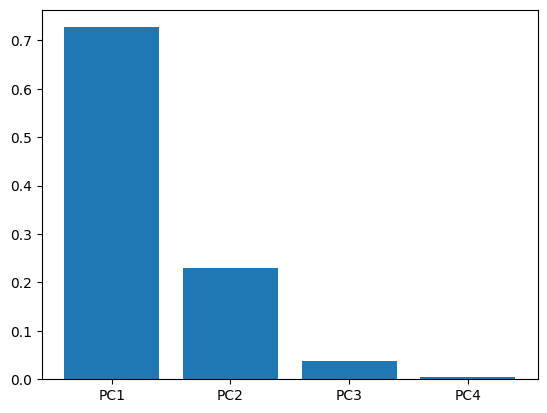

In [15]:
# Cria labels para o eixo x
labels = [f'PC{i+1}' for i in range(X_train.shape[1])]

# Faz um gráfico de barras da explained_variance_ratio_
plt.bar(labels, pca.explained_variance_ratio_)
plt.show()

O gráfico acima é conhecido como Scree plot. Ele mostra o autovalor no eixo y para cada uma das componentes. Também podemos fazer um gráfico mostrando a soma cumulativa das porcentagens de variância explicadas:

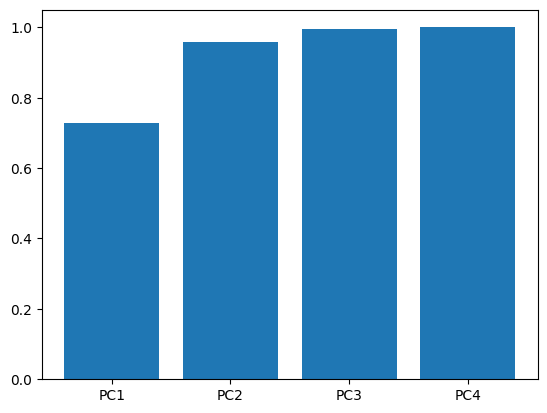

In [16]:
# gráfico de barras do pca.explained_variance_ratio_.cumsum()
plt.bar(labels, pca.explained_variance_ratio_.cumsum())
plt.show()

Utilizamos esses dois gráficos para definir quantas componentes principais queremos no nosso modelo.

### 1.3) Como escolher L (número de dimensões no novo espaço de features)?
Se o nosso Scree plot apresentar autovalores (coeficientes de cada componente $PC_i$) com valores similares, como mostrado na figura abaixo, podemos concluir que os nossos dados já estão projetados em um bom espaço e não precisamos transformá-los.

<img src="images/not_good_pca.png" text="https://www.youtube.com/watch?v=FgakZw6K1QQ" width=300>

No nosso caso, os autovalores de $PC_1$ e $PC_2$ são bem maiores que os demais indicando que eles contém a maior parte da informação sobre a distribuição dos dados. Com apenas essas 2 componentes principais capturamos 95% da variância dos dados!

Isso porque autovalores que são próximos de zero contém menos informação e podem ser descartados do novo espaço de features.


Assim, caso queiramos reduzir o número de dimensões de $n=4$ para $L=2$, temos a garantia de que grande parte da variabilidade estará contida nas duas componentes principais que usaremos para modelagem!

> Veja que a escolha de $L < n$ componentes principais pode ser visto como um procedimento de **feature selection**, mas feito **no espaço de componentes principais!**
> Como não são as features originais que são selecionadas, é comum nos referirmos a este procedimento como **redução de dimensionalidade** (e a dimensionalidade que é reduzida é do espaço de componentes principais!)

De fato, note que **todas as 4 features originais** estão presentes em cada uma das PCs, como termos da combinação linear que define cada PC. E, naturalmente, todas as 4 estão presentes nas $L$ primeiras.

Caso queiramos construir modelos no espaço de componentes principais, é importante que incorporemos o PCA em nossa pipeline! 

Vamos ver na prática!

____________

## 2) PCA na Pipeline

In [17]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Primeiro vamos criar uma pipeline simples só para obter as métricas para o modelo sem PCA:


Métricas de avaliação de treino:


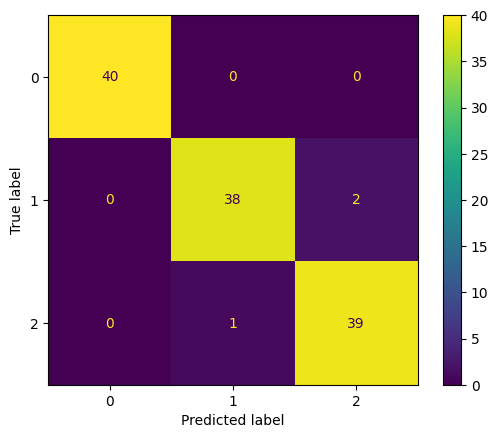

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.95      0.96        40
           2       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


Métricas de avaliação de teste:


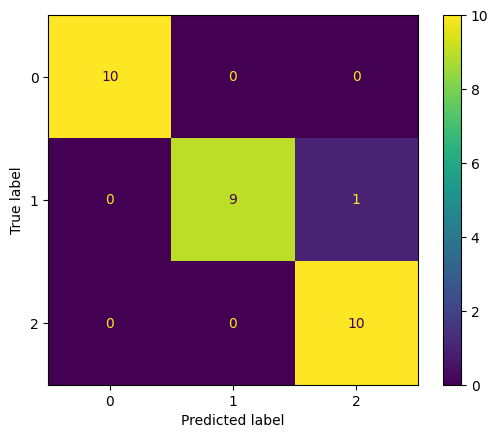

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [27]:
# pipeline do LogisticRegression
pipe = Pipeline([
    ('model', LogisticRegression(random_state=42))
])

# Fit do pipe no treino e teste
pipe.fit(X_train, y_train)

# printa metricas_classificacao
metricas_classificacao(pipe, X_train, X_test, y_train, y_test)


Agora vamos adicionar na pipeline o StandardScale e o PCA com duas componentes (n_components=2):


Métricas de avaliação de treino:


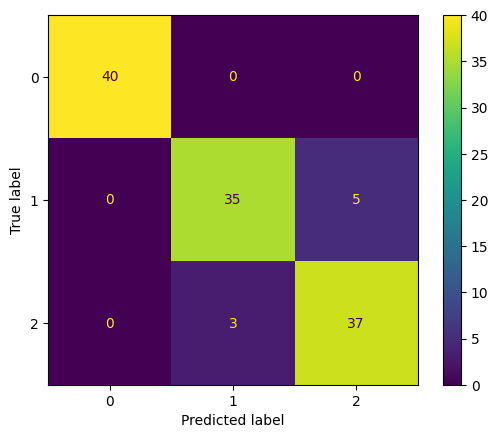

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.92      0.88      0.90        40
           2       0.88      0.93      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Métricas de avaliação de teste:


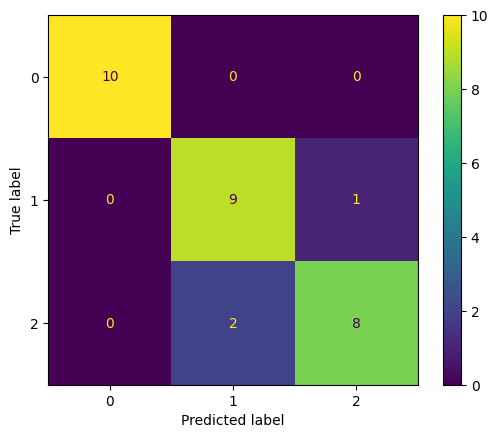

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [30]:
pipe_2 = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components=2, random_state = 42)),
    ('model', LogisticRegression(random_state = 42))
])

# fit do pipe
pipe_2.fit(X_train, y_train)

# printa metricas_classificacao
metricas_classificacao(pipe_2, X_train, X_test, y_train, y_test)

Em vez de instanciarmos o PCA com duas componentes, queremos que ele retorne a quantidade de componentes que expliquem pelo menos 90% da variância dos nossos dados (n_components=0.9):  


Métricas de avaliação de treino:


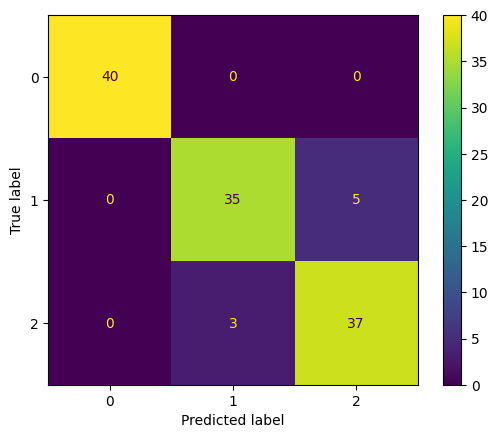

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.92      0.88      0.90        40
           2       0.88      0.93      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Métricas de avaliação de teste:


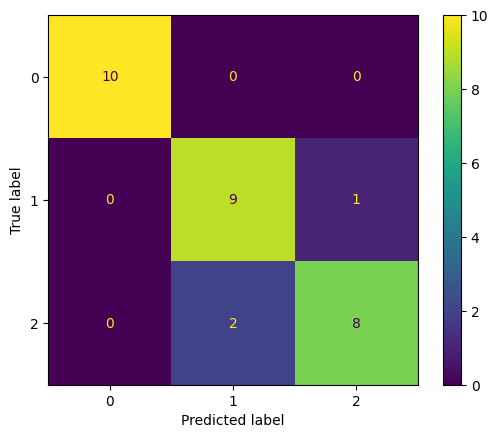

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [31]:
pipe_2 = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components=0.9, random_state = 42)),
    ('model', LogisticRegression(random_state = 42))
])

# fit do pipe
pipe_2.fit(X_train, y_train)

# printa metricas_classificacao
metricas_classificacao(pipe_2, X_train, X_test, y_train, y_test)

In [33]:
pipe.get_params()

{'memory': None,
 'steps': [('model', LogisticRegression(random_state=42))],
 'verbose': False,
 'model': LogisticRegression(random_state=42),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': 42,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [52]:
pipe_2['pca'].n_components_

2

In [56]:
oi = pipe_2['pca']

In [57]:
oi.n_components_

2

In [55]:
pipe_2.steps[1][-1].n_components_

2

___________

Vamos analisar um outro dataset?


A base [MNIST](https://www.kaggle.com/c/digit-recognizer/data) contém 42 mil imagens (28 x 28 px) de dígitos manuscritos que vão de 0 a 9. Para cada imagem estão associados $28^2 = 784$ pixels que podem ser representados por uma matriz de features $$X(42.000, 784)$$

Cada pixel será representado como uma feature distinta e terá o valor 255 se o pixel for preto, 0 se branco e valores intermediários correspondendo aos tons de cinza.

Nosso target, $Y(42.000, )$ é um vetor cujas componentes são inteiros de 0 a 9 que representam os dígitos.


In [59]:
import random, itertools
random.seed(42)

In [60]:
train = pd.read_csv('../data/mnist_train.csv')

y = train['label']
X = train.drop("label",axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
30444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
y_train

30444    8
20563    9
5726     9
22312    1
3677     9
        ..
20648    5
41285    6
39202    0
24750    0
28581    3
Name: label, Length: 33600, dtype: int64

In [63]:
X_train.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,...,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.0,33600.0,33600.0,33600.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.189851,0.097054,0.032649,0.016429,0.016964,0.003571,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.815465,4.074927,2.412079,1.754433,1.944391,0.463160,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,252.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### Redução de dimensionalidade - PCA
Vamos olhar nesse momento todas as componentes para tentar determinar qual o melhor valor para o novo espaço dimensional (L).

In [76]:
# Instancia o PCA e o scaler
pca = PCA()
scaler = StandardScaler()

# Aplica o scaler
X_sc = scaler.fit_transform(X_train)

# Fita o pca
pca.fit(X_sc)

# Constrói o acumulado de aumento da variância em %
accumulated_sum = pca.explained_variance_ratio_.cumsum()*100


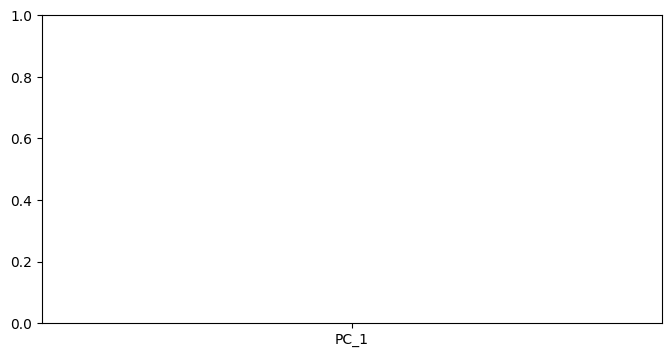

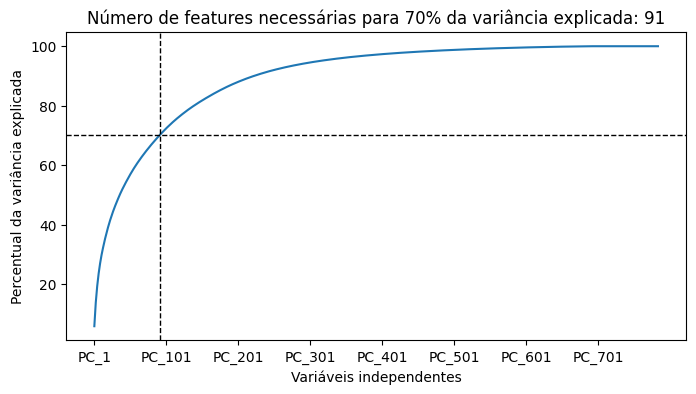

In [77]:
import matplotlib.ticker as ticker

# Cria labels para o eixo x
labels = [f"PC_{i+1}" for i in range(pca.n_components_)]

# Define um threshold para a variância explicada
threshold=70

# Calcula quantas features são necessárias para obter esse threshold
number_of_features = list(accumulated_sum >= threshold).index(True)

# Cria espaço da figura
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plota a soma acumulada
ax.plot(labels, accumulated_sum)

# Plota linha horizontal com o threshold da variância
ax.axhline(y=threshold, color="black", linestyle="--", linewidth=1)

# Plota linha vertical com a quantidade de features necessárias para esse threshold
ax.axvline(x=number_of_features, color="black", linestyle="--", linewidth=1)

# Seta tickers pro x
xticks_index = np.arange(0, X.shape[0+1], 100)
ax.xaxis.set_major_locator(ticker.FixedLocator(xticks_index))

# Seta título e texto dos eixos
ax.set_title(f"Número de features necessárias para {threshold}% da variância explicada: {number_of_features}")
ax.set_xlabel("Variáveis independentes"), plt.ylabel("Percentual da variância explicada")
plt.show()


In [78]:
# instancia o PCA com n_components igual ao número de features escolhido
pca = PCA(n_components=number_of_features)

# Cria um novo dataframe X_pca com os dados de treino no novo espaço de componentes
X_pca = pca.fit_transform(X_sc)


Vamos observar o efeito da reconstrução de uma imagem com as componentes principais e compará-lo com sua versão original:

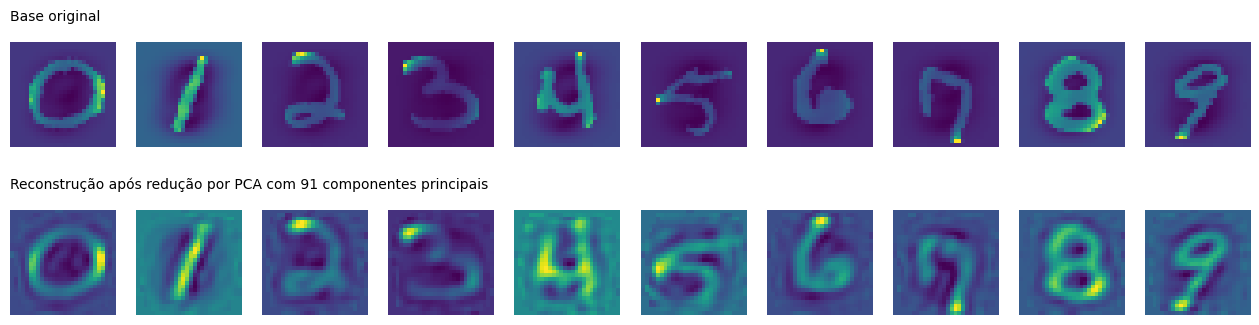

In [79]:
# Converte X_train e y_train em arrays
X_array = np.array(X_sc)
y_array = np.array(y_train)

# Cria área da figura
fig, ax = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 4))

# Remove os valores dos eixos
[i.set_axis_off() for i in fig.axes]

# Escreve texto acima da imagem
plt.text(0, 1.2, "Base original", 
         fontdict=None, transform=ax[0, 0].transAxes)

# Plota imagens originais
[ax[0, j].imshow(X_array[n].reshape(28, 28), 
     ) for j, n in enumerate([list(y_array == k).index(True) for k in range(10)])]

# Escreve texto acima da imagem
plt.text(0, 1.2, f"Reconstrução após redução por PCA com {number_of_features} componentes principais", 
         fontdict=None, transform=ax[1, 0].transAxes)

# Plota imagens geradas a partir das componentes principais
[ax[1, j].imshow(
     pca.inverse_transform(X_pca[n]).reshape(28, 28)) for j, n in enumerate([list(y_array == k).index(True) for k in range(10)])]

plt.show()    

Podemos perceber que houve uma redução na nitidez dos dígitos, mas ainda é possível reconher quais são os valores manuscritos em cada imagem.

Agora que sabemos quantas features são necessárias para explicar 90% da variância dos nossos dados vamos criar um pipeline para extrair essas features e treinar um modelo.


Métricas de avaliação de treino:


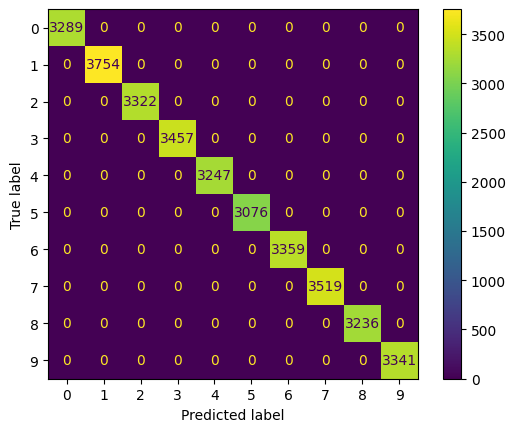

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3289
           1       1.00      1.00      1.00      3754
           2       1.00      1.00      1.00      3322
           3       1.00      1.00      1.00      3457
           4       1.00      1.00      1.00      3247
           5       1.00      1.00      1.00      3076
           6       1.00      1.00      1.00      3359
           7       1.00      1.00      1.00      3519
           8       1.00      1.00      1.00      3236
           9       1.00      1.00      1.00      3341

    accuracy                           1.00     33600
   macro avg       1.00      1.00      1.00     33600
weighted avg       1.00      1.00      1.00     33600


Métricas de avaliação de teste:


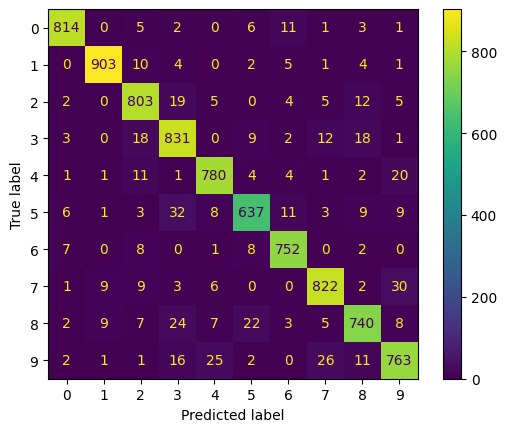

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       843
           1       0.98      0.97      0.97       930
           2       0.92      0.94      0.93       855
           3       0.89      0.93      0.91       894
           4       0.94      0.95      0.94       825
           5       0.92      0.89      0.90       719
           6       0.95      0.97      0.96       778
           7       0.94      0.93      0.94       882
           8       0.92      0.89      0.91       827
           9       0.91      0.90      0.91       847

    accuracy                           0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



In [81]:
from sklearn.ensemble import RandomForestClassifier

# Cria pipeline de processamento dos dados com StandardScale e PCA
preprocessing = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=222))
])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestClassifier(random_state=42))
])
# Faz o fit do pipeline no X e y
pipe.fit(X_train, y_train)

# Printa as métricas de classificação
metricas_classificacao(pipe, X_train, X_test, y_train, y_test)

____________
## Prós e Contras
#### Prós:
- Remove features correlacionadas: como todas as componentes principais são independentes entre si não temos mais correlação entre as features nesse novo espaço.
- Diminui o tempo de treino
- Pode melhorar a performance do algorítimo
- Reduz overfiting (mas não é o melhor método, sempre dê preferência para alguma regularização)

#### Contras:
- Fica mais difícil interpretar o modelo já que agora suas features são combinações lineares das features originais
- É obrigatório termos os dados na mesma escala (mean = 0 e standard deviation = 1)
- Perda de informação
- Não é recomendado utilizar com dados categóricos
- Nessa classe que utilizamos o dataset inteiro precisa caber na RAM ([Incremental PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA))
- Consegue detetar apenas relações lineares  ([Kernel PCA](https://scikit-learn.org/stable/modules/decomposition.html#kernel-principal-component-analysis-kpca))
- Não leva em consideração o target na hora de criar as componentes principais (LDA)
- Se os dados não seguem uma gaussiana multidimensional, o PCA pode não resultar nas melhores componentes.
<img src=https://miro.medium.com/max/690/1*X_Q55Ab2FUv6sF7XqAE0tw.png width=500>

## Bibliografia
- [Exemplo de PCA aplicado em reconhecimento facial](https://www.ritchieng.com/machine-learning-dimensionality-reduction-feature-transform/)
- [Outros métodos de extração de features: ICA, LDA, LLE, t-SNE e AE](https://towardsdatascience.com/feature-extraction-techniques-d619b56e31be)
- [Exemplo no dataset Fashion MNIST](https://www.kaggle.com/code/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist/notebook)
- [Visualização do MNIST](https://data-science-blog.com/blog/2020/11/23/pca-and-lda/)
- [MCA: o PCA das variáveis categóricas](https://pypi.org/project/mca/)
- [Non linear PCA](https://scholarlypublications.universiteitleiden.nl/handle/1887/12386)


# Aprofundamento

## 3) A matemática do PCA

(Adaptado do notebook do Walisson!)

__________

Considere a matriz de features $X_{N \times n}$

> $N$ linhas (observações), cada uma caracterizada por $n$ features no espaço original.

Cada observação $i$ é caracterizada pelo vetor de features $\vec{x}_i = (x_{i1}, x_{i2}, \cdots, x_{in}$), que são as linhas da matriz de features:

$$
  X = \left [ \begin{array}{ccccc}
x_{11} & x_{12} & x_{13} & \cdots & x_{1n}\\ 
x_{21} & x_{22} & x_{23} & \cdots & x_{2n}\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
x_{N1} & x_{N2} & x_{N3} & \cdots & x_{Nn}\\ 
   \end{array} \right ] 
$$

### Passo 1 - standardização

Para dados em que as features originais $x_j$ estão em escalas diferentes, é necessário escalar os dados para que eles tenham média 0 e desvio padrão 1 (ou seja, usamos o `StandardScaler`). 

Isso porque os componentes são influenciados pela escala das variáveis, justamente porque as matrizes de covariâncias, $\Sigma$ ou $\hat{\Sigma} = S$, são sensíveis à escala de um par de variáveis. 

Considere:

- $\bar{x}_j$ a média da variável $x_j$; 
- $s(x_j)$ o desvio padrão de $x_j$; 

Sendo $i = 1, 2,3,4,\cdots, N$ e $j = 1, 2,3,4,\cdots, n$.

Com isso, a padronização pode ser realizada por meio da equação abaixo: 

- Média 0 e desvio padrão 1: 

$$ \tilde{x}_{ij}= \frac{x_{ij}-\bar{x_j}}{s(X_j)} $$ 

<br>

### Passo 2 - cálculo da matriz de covariância

Calcular a matriz de **covariância**/**correlação**, que são dadas por:

$$
  S = \left [ \begin{array}{ccccc}
\hat{Var}(x_1) & \hat{Cov}(x_1x_2) & \hat{Cov}(x_1x_3) & \cdots & \hat{Cov}(x_1x_n)\\ 
\hat{Cov}(x_2x_1) &\hat{Var}(x_2)& \hat{Cov}(x_2x_3) & \cdots & \hat{Cov}(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
\hat{Cov}(x_nx_1) & \hat{Cov}(x_nx_2)  & \hat{Cov}(x_nx_3)  & \cdots & \hat{Var}(x_n)\\ 
   \end{array} \right ] 
$$

<br>
<br>

$$
  R = \left [ \begin{array}{ccccc}
1 & r(x_1x_2) & r(x_1x_3) & \cdots & r(x_1x_n)\\ 
r(x_2x_1) & 1 & r(x_2x_3) & \cdots & r(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
r(x_nx_1) & r(x_nx_2)  & r(x_nx_3)  & \cdots & 1\\ 
   \end{array} \right ] 
$$

Em que:

$$
 \begin{array}{ccc}
\hat{Var}(x_j) = \frac{\sum_{i=1}^{N}(x_{ij}-\bar{x}_j)}{N-1}, & 
\hat{Cov}(x_{j1},x_{j2}) = \frac{\sum_{i=1}^N(x_{ij1}-\bar{x_{j1}})(x_{ij2}-\bar{x_{j2}})}{N-1}, &
r(x_{j1},x_{j2}) = \frac{\hat{Cov}(x_{j1},x_{j2})}{S_{xj1}S_{xj2}}
   \end{array} 
$$

<br>

### Passo 3 - determinação de autovalores e autovetores

As componentes principais são determinadas através da equação característica (equação de autovalores) da matriz S ou R:

$$det[R - \lambda I]= 0 $$

Em que $I$ é a matriz identidade de dimensão $n \times n $. 

Se R ou S tem posto completo igual a $n$, então $det[R - \lambda I]= 0$, que pode ser reescrito como $\mid R - \lambda I \mid = 0$, terá $n$ soluções. Lembrando que ter posto completo significa que nenhuma coluna é combinação linear de outra.

Considere que $\lambda_1,\lambda_2,\lambda_3, \cdots, \lambda_n$ sejam as raízes da equação característica de R ou S, então temos que  $\lambda_1 > \lambda_2 > \lambda_3 > \cdots, \lambda_n$. 

Chamamos $\lambda_i$ de **autovalores**. 

Além disso, para cada autovalor há um **autovetor** $\tilde{a}_i$ associado, $
  \tilde{a}_i = \left [ \begin{array}{c}
a_{i1}\\ 
a_{i2}\\ 
\vdots \\
a_{ip} \\ 
   \end{array} \right ] 
$

O cálculo do autovetor $\tilde{a}_i$, pode ser realizado considerando a seguinte propriedade:

$$ R\tilde{a}_i =  \lambda_i \tilde{a}_i $$

O autovetor deve ser normalizado, isso é,

$$ a_i = \frac{\tilde{a}_i }{\mid \tilde{a}_i  \mid}$$

Desta maneira, as componentes do vetor são tais que sua norma L2 é igual a 1.

<br>

### Passo 4 - cálculo das componentes principais

O cálculo da i-ésima componente principal é dado por:

$$PC_i = a_{i1}x_1 + a_{i2}x_2 + a_{i3}x_3 + \cdots + a_{in}x_n $$

em que $a_{i1}$ são as componetes do autovetor $a_i$ associado ao autovalor $\lambda_i$.

__________

Operacionalmente, o PCA se apoia em um procedimento matemático denominado **Singular Value Decomposition (SVD)**, que é uma forma de decompor qualquer matriz não quadrada $M_{m\times n}$,

$$M_{m\times n} = U_{m \times m}\Sigma_{m \times n}V_{n \times n}^{\dagger}$$

- onde $U$ é uma matriz unitária $m\times m$ real ou complexa;

- $\Sigma$ é uma matriz retangular diagonal $m\times n$ com números reais não-negativos na diagonal;

- e $V^{\dagger}$ (a conjugada transposta de $V$) é uma matriz unitária $n\times n$ real ou complexa. 

Os valores de $\Sigma$ são os chamados valores singulares de $M$. As $m$ colunas de $U$ e as $n$ colunas de $V$ são os chamados vetores singulares à esquerda e vetores singulares à direita de $A$, respetivamente.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png width=300>

## Outros métodos

### [LDA (Linear Discriminant Analysis)](http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

<img src=https://i.stack.imgur.com/Tz5mA.png width=500>

[Prince](https://github.com/MaxHalford/prince) é um pacote do python que tem métodos implementados para lidar com vários tipos de bases:

<img src=http://www.sthda.com/english/sthda-upload/images/principal-component-methods/multivariate-analysis-factoextra.png text="http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/">

# Exercício
Aplique o PCA nos dados do projeto e verifique se houve melhora na predição do modelo.

# Tarefa
Com os dados do breast_cancer, encontre um bom valor para a quantidade de componentes principais e treine um modelo com pipeline.

In [ ]:
df_bc = pd.read_csv("../datasets/breast_cancer.csv")

X = df_bc.drop(columns=["id", "diagnosis"])
y = df_bc["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)